# Dataset

In [2]:
import torchvision
transform = transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dst=torchvision.datasets.ImageFolder(root='/home/st/common_dataset/common_dataset/miniImageNet/Ravi/train', transform=transform)

torch.Size([3, 256, 256])


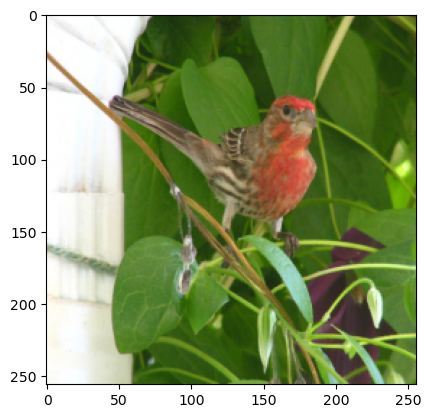

In [7]:
dst.__getitem__(0), dst.__getitem__(1), dst.__getitem__(2), dst.__getitem__(3)
item=dst.__getitem__(3)[0]
print(item.size())
# to image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.transpose(item.numpy(), (1, 2, 0)))


# custom upscaler

In [12]:
import torch
import torch.nn as nn

class CNNSuperResolutionNet(nn.Module):
    def __init__(self):
        super(CNNSuperResolutionNet, self).__init__()
        
        # Feature extraction
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Upsampling
        self.upsample1 = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Upsampling
        self.upsample2 = nn.PixelShuffle(2)
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Feature extraction
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        # Upsampling
        x = self.upsample1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        
        # Upsampling
        x = self.upsample2(x)
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        
        return x

model = CNNSuperResolutionNet()    
input_image = torch.randn(1, 3, 64, 64)  # Batch size 1
print('input image size:', input_image.size())
output_image = model(input_image)
print('output image size:', output_image.size())

from torchsummary import summary
model = CNNSuperResolutionNet()

summary(model.cuda(), (3, 64, 64))

input image size: torch.Size([1, 3, 64, 64])
output image size: torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
      PixelShuffle-5         [-1, 16, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]           9,280
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              ReLU-9         [-1, 64, 128, 128]               0
     PixelShuffle-10         [-1, 16, 256, 256]               0
           Conv2d-11         [-1, 32, 256, 256]           4,640
             ReLU-12         [-1, 32, 256, 256]               0
          

/home/st/anaconda3/envs/bird/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [1]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNetSuperResolutionNet(nn.Module):
    def __init__(self, num_residual_blocks=16):
        super(ResNetSuperResolutionNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64, 64) for _ in range(num_residual_blocks)])

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upsample1 = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upsample2 = nn.PixelShuffle(2)
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.residual_blocks(x)
        x = self.relu(self.conv2(x))

        x = self.upsample1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        x = self.upsample2(x)
        x = self.relu(self.conv5(x))
        x = self.conv6(x)

        return x

model = ResNetSuperResolutionNet()    
input_image = torch.randn(1, 3, 64, 64)  # Batch size 1
print('input image size:', input_image.size())
output_image = model(input_image)
print('output image size:', output_image.size())

from torchsummary import summary
model = ResNetSuperResolutionNet()

summary(model.cuda(), (3, 64, 64))

input image size: torch.Size([1, 3, 64, 64])
output image size: torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
              ReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
     ResidualBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,928
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
          

/home/st/anaconda3/envs/bird/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [35]:
import torch
import torch.nn as nn
from einops import rearrange

class ViTSuperResolutionNet(nn.Module):
    def __init__(self, patch_size=4, channels=3, num_heads=8, num_layers=6, hidden_dim=512, upscale_factor=4):
        super(ViTSuperResolutionNet, self).__init__()
        self.patch_size = patch_size
        self.channels = channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.upscale_factor = upscale_factor
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        
        self.patch_embedding = nn.Conv2d(channels, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.randn(1, (64 // patch_size) ** 2 + 1, hidden_dim))
        self.dropout = nn.Dropout(0.1)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim * 4, dropout=0.1),
            num_layers=num_layers
        )
        
        self.upsampler = nn.PixelShuffle(upscale_factor // 2)
        self.output = nn.Conv2d(hidden_dim // (upscale_factor // 2) ** 2, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embedding(x)  # (batch_size, hidden_dim, height//patch_size, width//patch_size)
        # import pdb; pdb.set_trace()
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = torch.cat([self.cls_token, x], dim=1)
        # print('x shape:', x.shape)
        # print('position_embedding shape:', self.position_embedding.shape)

        # Add position embedding
        x += self.position_embedding
        
        # Apply transformer encoder
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        
        # Upsampling and reconstruction
        # remove cls_token
        # import pdb; pdb.set_trace()
        x = x[:, 1:, :]
        x = rearrange(x, 'b (h w) c -> b c h w', h=64 // self.patch_size)
        x = self.upsampler(x)
        x = self.output(x)
        
        return x


model = ViTSuperResolutionNet()    
input_image = torch.randn(1, 3, 64, 64)  # Batch size 1
print('input image size:', input_image.size())
output_image = model(input_image)
print('output image size:', output_image.size())

# from torchsummary import summary
# model = ViTSuperResolutionNet()  

# summary(model.cuda(), (3, 64, 64))

input image size: torch.Size([1, 3, 64, 64])
output image size: torch.Size([1, 3, 32, 32])


In [38]:
import torch
import torch.nn as nn
from einops import rearrange

class ViTSuperResolutionNet(nn.Module):
    def __init__(self, patch_size=4, channels=3, num_heads=8, num_layers=6, hidden_dim=512, upscale_factor=4):
        super(ViTSuperResolutionNet, self).__init__()
        self.patch_size = patch_size
        self.channels = channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.upscale_factor = upscale_factor

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.patch_embedding = nn.Conv2d(channels, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.randn(1, (64 // patch_size) ** 2 + 1, hidden_dim))
        self.dropout = nn.Dropout(0.1)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim * 4, dropout=0.1),
            num_layers=num_layers
        )

        self.conv_before_upsample = nn.Conv2d(hidden_dim, hidden_dim // 4, kernel_size=1)
        self.upsampler1 = nn.PixelShuffle(2)
        self.upsampler2 = nn.PixelShuffle(2)
        self.output = nn.Conv2d(hidden_dim // 16, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embedding(x)  # (batch_size, hidden_dim, height//patch_size, width//patch_size)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = torch.cat([self.cls_token, x], dim=1)

        # Add position embedding
        x += self.position_embedding

        # Apply transformer encoder
        x = self.dropout(x)
        x = self.transformer_encoder(x)

        # Upsampling and reconstruction
        x = x[:, 1:, :]  # Remove cls_token
        x = rearrange(x, 'b (h w) c -> b c h w', h=64 // self.patch_size)
        x = self.conv_before_upsample(x)  # Reduce channels to hidden_dim // 4
        x = self.upsampler1(x)
        x = self.upsampler2(x)
        x = self.output(x)

        return x

model = ViTSuperResolutionNet()    
input_image = torch.randn(1, 3, 64, 64)  # Batch size 1
print('input image size:', input_image.size())
output_image = model(input_image)
print('output image size:', output_image.size())


input image size: torch.Size([1, 3, 64, 64])


RuntimeError: Given groups=1, weight of size [3, 32, 3, 3], expected input[1, 8, 64, 64] to have 32 channels, but got 8 channels instead

# Swin upsclaer (todo)

In [ ]:
# import torchsummary
import torch.nn as nn

import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.datasets import ImageNet
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch.optim.lr_scheduler as lr_scheduler
import torchvision


class SwinIRBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, groups=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

class SwinIRDownsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        return self.downsample(x)

class SwinIRUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x):
        return self.upsample(x)

class SwinIR(nn.Module):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        self.learning_rate = learning_rate

        # Define the SwinIR architecture
        self.conv1 = SwinIRBlock(3, 64)
        self.downsample1 = SwinIRDownsample(64, 128)
        self.conv2 = SwinIRBlock(128, 128)
        self.downsample2 = SwinIRDownsample(128, 256)
        self.conv3 = SwinIRBlock(256, 256)
        self.upsample1 = SwinIRUpsample(256, 128, output_padding=1)
        self.conv4 = SwinIRBlock(256, 128)
        self.upsample2 = SwinIRUpsample(128, 64, output_padding=1)
        self.conv5 = SwinIRBlock(128, 64)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.downsample1(x)
        x = self.conv2(x)
        x = self.downsample2(x)
        x = self.conv3(x)
        x = self.upsample1(x)
        x = self.conv4(x)
        x = self.upsample2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        return x

from torchsummary import summary
model = SwinIR()

summary(model.cuda(), (3, 64, 64))



RuntimeError: Given groups=1, weight of size [128, 256, 3, 3], expected input[2, 128, 32, 32] to have 256 channels, but got 128 channels instead